In [1]:
'''
    图像辨识: 语义分割、目标检测、定位、实例分割

    目标检测要同时识别对象的类别和位置:
    1.分类(Classification): 辨识对象的类别
    2,回归(Regression):找到对象的位置,包括对象左上角的坐标和宽度/高度
'''
# 滑动窗口算法
'''
    裁剪窗口 ---> 辨识窗口内是否有对象 --->滑动窗口 -->缩小原图尺寸 --->回到步骤1,辨识大尺寸对象
'''
import cv2
import time
import imutils

# 1.定义金字塔操作函数
## 参数: 原图, 每次缩小倍数, minSize:最小尺寸
def pyramid(image, scale=1.5, minSize=(30, 30)):
    yield image
    while True:
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        yield image
# 2.滑动窗口函数
def sliding_window(image, stepSize, windowSize):
    for y in range(0, image.shape[0], stepSize): #向下滑动stepSize格
        for x in range(0, image.shape[1], stepSize): #向右滑动stepSize格
            # 传回裁剪后的窗口
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

# 4.测试
image = cv2.imread("./img/1.jpg")

## 窗口尺寸
winW,winH = 128,128

## 获取金字塔的各种尺寸
for resized in pyramid(image, scale=1.5):
    ### 滑动窗口
    for (x,y,window) in sliding_window(resized, stepSize=32, windowSize=(winW,winH)):
        # 窗口尺寸不合适即放弃,滑动到边缘时,尺寸过小
        if window.shape[0] != winH or window.shape[1] != winW:
            continue
        # 标示滑动的窗口
        clone = resized.copy()
        cv2.rectangle(clone, (x,y), (x+winW,y+winH), (0,255,0),2)
        cv2.imshow("Window", clone)
        cv2.waitKey(1)

        time.sleep(0.025)

# 结束时关闭窗口
cv2.destroyAllWindows()

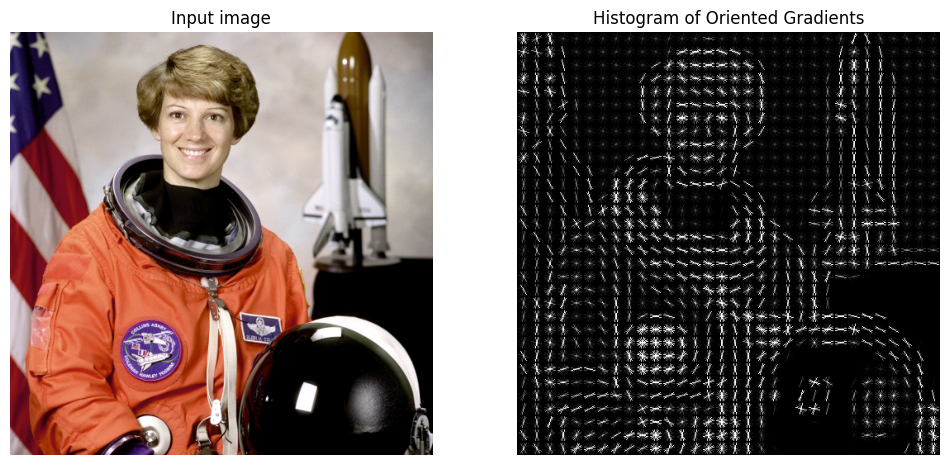

In [ ]:
'''
    方向梯度直方图(Histogram of oriented gradient,HOG)
        1.收集正/负样本: 集结目标对象的各式图像样本,包括不同视角、尺寸、背景的图像; 集结无目标对象的各式图像样本,若有找到相近的对象则更好,可以增加辨识准确率
        2.模型训练: 使用以上正/负样本与分类算法训练二分类模型,判断是否包含目标对象,一般使用支持向量机(SVM)算法
        3.Hard-negativeMinin: 扫描负样本,使用滑动窗口的技巧,将每个窗口导入模型来预测,如果有检测到目标对象,即是伪阳性(False Positive),接着将这些图像加到
    训练数据集中进行重新训练。
        4.重新训练模型
        5.目标检测

    使用HOG、滑动窗口以及SVM进行目标检测
'''
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data,exposure

# 2.HOG测试:
image =data.astronaut()

## 取得图片的HOG
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True,  channel_axis=2)

## 原图与HOG图比较
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6),sharex=True,sharey=True)

ax1.axis('off')
ax1.imshow(image,cmap=plt.cm.gray)
ax1.set_title('Input image')

## 调整对比,让显示比较清楚
hog_image_rescaled = exposure.rescale_intensity(hog_image,in_range=(0,10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled,cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

# 3.收集正样本
from sklearn.datasets import fetch_lfw_people
from sklearn.feature_extraction.image import PatchExtractor

faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

# 4.观察正样本中部分图片
fig,ax = plt.subplots(4,6)
for i,axi in enumerate(ax.flat):
    axi.imshow(positive_patches[500 * i],cmap='gray')
    axi.axis('off')

# 5.收集负样本
from skimage import data,transform,color

imgs_to_use = ['hubble_deep_field','text','coins','moon','page','clock','coffee','chelsea','horse']

images = [color.rgb2gray(getattr(data,name)()) for name in imgs_to_use]
len(images)

## 增加负样本批数
def extract_patches(img,N,scale=1.0,patch_size=(50,50)):
    h,w = img.shape
    HP,WP = patch_size
    patches = []
    for i in range(N):
        patch = transform.pyramid_reduce(img,scale=scale,mode='constant')
        h,w = patch.shape
        if h < HP or w < WP:
            continue
        start_y = np.random.randint(0,h-HP)
        start_x = np.random.randint()
